In [2]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean, get_MOI, get_pendulum_invariance, get_SHM_invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_SHM_data, get_pendulum_data, get_grid_of_points_1D, evaluate_model_future, evaluate_model_grid, SHM_dynamics, pendulum_dynamics
from parameterised_invariance_kernels import get_polynomial_invariance
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

In [117]:
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time = 3

max_x = 150
max_v = 10
n_train = 3 
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_pendulum_data(time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[-93.3724  14.7379 -41.2284]
[ 1.4297 -7.3934 -3.7576]


In [120]:

moi = get_GPR_model(get_MOI(), mean, data, 500)
print("moi:"+format(moi.log_marginal_likelihood().numpy(),".2f"))
jitter = 1e-5
invar_density = 20
latex=""
try:
    kernel = get_pendulum_invariance(np.radians(150), invar_density, jitter) #switch
    known = get_GPR_model(kernel, mean, data, 500)
    print("known: "+format(known.log_marginal_likelihood().numpy(),".2f"))
    i = 0
    for poly_f_d in [3]:
        for poly_g_d in [4]:
            kernel = get_polynomial_invariance(np.radians(150), invar_density, jitter, poly_f_d, poly_g_d) #switch
            m = get_GPR_model(kernel, mean, data, 3000)
            print("(%s, %s)----------------------"%(poly_f_d-1, poly_g_d-1))
            np.set_printoptions(precision=4)
            print(kernel.f_poly.numpy())
            print(kernel.g_poly.numpy())
            print(format(m.log_marginal_likelihood().numpy(),".2f"))
            latex+=format(m.log_marginal_likelihood().numpy(),".2f")
            i+=1
            if i%9==0:
                latex+='\\'
            else:
                latex+="&"
except tf.errors.InvalidArgumentError:
    print("jitter too small")

moi:233.20
known: 263.35
(2, 3)----------------------
[[3.6449e-04]
 [9.7752e-01]
 [3.3138e-05]]
[[ 0.0013]
 [ 0.9623]
 [ 0.0215]
 [-0.1222]]
257.20


In [119]:
latex

'233.19&233.19&233.04&231.08&215.58&-778657.91&230.56&241.84&71.94\\-55.00&-57.43&221.83&230.54&245.13&232.63&257.56&nan&-100349.16\\227.73&242.15&-83384.19&-53.35&217.43&231.41&229.79&240.80&229.65\\-32024.85&251.19&nan&188.66&242.33&nan&nan&225.38&nan\\'

In [51]:
import importlib, sys
importlib.reload(sys.modules["invariance_functions"])
from invariance_functions import evaluate_model_future

In [129]:


eva_future_moi = []
eva_future_inv = []
eva_future_inv_p = []

grids = (np.radians(150), 40)
dynamics = pendulum_dynamics

lml_moi = moi.log_marginal_likelihood().numpy()
lml_inv = known.log_marginal_likelihood().numpy()
lml_inv_p = m.log_marginal_likelihood().numpy()

grid_moi = (evaluate_model_grid(moi, grids, dynamics))
grid_inv = (evaluate_model_grid(known, grids, dynamics))
grid_inv_p = (evaluate_model_grid(m, grids, dynamics))
print(lml_moi)
print(lml_inv)
print(lml_inv_p)

for i in range(1):
    print(i)
    test_starting_position = np.radians(np.random.uniform(-max_x, max_x))
    test_starting_velocity = np.radians(np.random.uniform(-max_v, max_v))

#    print(test_starting_position)
#    print(test_starting_velocity)
    test_starting = (test_starting_position, test_starting_velocity)
    time_setting = (testing_time, time_step)

    evaluate_moi = evaluate_model_future(moi, test_starting, dynamics,time_setting)
    eva_future_moi.append(evaluate_moi[0])

    evaluate_invariance =evaluate_model_future(known, test_starting, dynamics,time_setting)
    eva_future_inv.append(evaluate_invariance[0])

    evaluate_invariance_p =evaluate_model_future(m, test_starting, dynamics, time_setting)#, (m.kernel.inv_f, m.kernel.inv_g), (lambda x: x, lambda x:np.sin(x)))
    eva_future_inv_p.append(evaluate_invariance_p[0])
    print(evaluate_invariance[0])


233.20449264934012
263.345921860632
257.19798382549607
0
0.0013304555284450977


In [123]:
print("Baseline RBF & " + format((lml_moi),".2f")+" & "+format(np.mean(eva_future_moi),".4f")+" & "+format((grid_moi),".4f")+' \\\\')
print("Invariance Kernel & "+ format((lml_inv),".2f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((grid_inv),".4f")+ ' \\\\')
print("Parameterised Invariance Kernel & "+ format((lml_inv_p),".2f")+" & "+format(np.mean(eva_future_inv_p),".4f")+" & "+format((grid_inv_p),".4f")+ ' \\\\')

Baseline RBF & 233.20 & 0.4336 & 1.0325 \\
Invariance Kernel & 263.35 & 0.0088 & 0.0084 \\
Parameterised Kernel & 257.20 & 0.0184 & 0.2797 \\


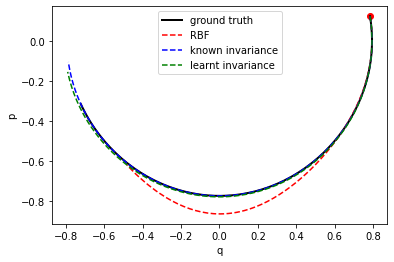

In [125]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="ground truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
plt.savefig("figures/parameterised_pendulum_predicted_trajectory.pdf")

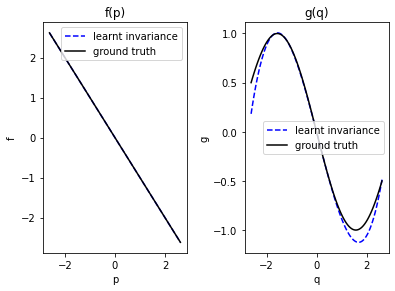

In [127]:

from numpy.polynomial import polynomial
x = np.linspace(-np.radians(150),np.radians(150),100)
multiplier = -m.kernel.f_poly.numpy()[1]
f = polynomial.Polynomial(np.squeeze(kernel.f_poly.numpy()))
g = polynomial.Polynomial(np.squeeze(kernel.g_poly.numpy()))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, f(x)/multiplier, "--", color="blue", label='learnt invariance')
ax1.plot(x, -x, label='ground truth', color="black")
ax1.set_title("f(p)")
ax1.set_xlabel("p")
ax1.set_ylabel("f")
ax1.legend()
ax2.set_title("g(q)")
ax2.plot(x, g(x)/multiplier, "--", color="blue",label='learnt invariance')
ax2.plot(x, -np.sin(x), color="black", label='ground truth')
ax2.legend()
ax2.set_xlabel("q")
ax2.set_ylabel("g")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig("figures/parameterised_pendulum_learnt_polynomial.pdf")



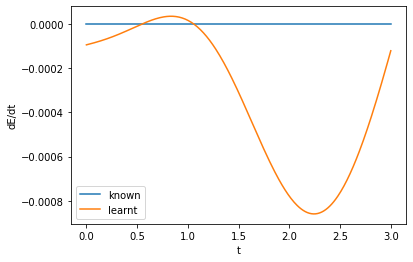

In [131]:
t = np.linspace(0, testing_time, int(testing_time/time_step))
plt.plot(t, tf.squeeze(evaluate_invariance_p[5]), label="known")
plt.plot(t, tf.squeeze(evaluate_invariance_p[6]), label="learnt")
plt.legend()
plt.xlabel("t")
plt.ylabel("dE/dt")
plt.savefig("figures/parameterised_pendulum_conservation_of_energy.pdf")